#  Prediction of BTC quotes

The goal of the project is to forecast BTC quotes for the next half hour using LSTM.

In [2]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import requests
import csv
import warnings
from keras.layers import Bidirectional
from keras.models import Sequential 
from keras.layers import Flatten, LSTM 
from keras.layers.core import Activation, Dropout, Dense 
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.sparse import coo_matrix, vstack
from phik.report import plot_correlation_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
warnings.filterwarnings('ignore')
sns.set()

## Data preparation

Since it is allowed to download only 500 points without registration, we will count everything in a cycle to combine into one dataframe from the beginning of the year to this day (to run without a Binance API profile)

In [4]:
names = ['Date', 'Open', 'High', 
             'Low', 'Close', 'Volume', 
             'Close Time', 'Quote Asset Volume', 
             'Number of Trades', 'Taker Buy Base Asset Volume', 
             'Taker Buy Quote Asset Volume', 'Ignore']
df = pd.DataFrame(columns = names)
df = df.set_index('Date')
start = int(datetime(2023, 1, 1).timestamp() * 1000) #first data
finish = int(datetime.now().timestamp() * 1000) #current data 
delta_time = 30 * 500 * 60 * 1000 #calculate time step
n_loops = int((finish - start) / delta_time) #necessary amount of cycles 

In [5]:
# Download data with 30 minutes step
def download_df(data_frame, names, start,finish):
    """Download dataset and join it with previous one"""
    
    
    url = "https://api.binance.com/api/v3/klines"
    params = {
        "symbol": "BTCUSDT",
        "interval": "30m",
        "startTime": start,
        "endTime": finish
    }
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data,columns = names)
    df = df.set_index('Date')
    df = pd.concat([data_frame,df])
    return df, df.index[-1]


s = start
for _ in range(n_loops+1):
    df, s = download_df(df,names,s,finish)
    
df_btc = df.copy()
df_btc.index = pd.to_datetime(df.index,unit='ms')

Convert our dataset to 'int' type

In [6]:
df_btc.to_csv('df_btc.csv')
df_btc.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
Date,,,,,,,,,,,
2022-12-31 21:00:00,16568.19000000,16571.64000000,16557.46000000,16563.84000000,1742.00907000,1672522199999,28856438.61787240,52514,847.17069000,14033607.92208840,0
2022-12-31 21:30:00,16563.57000000,16568.34000000,16544.12000000,16548.28000000,1876.76482000,1672523999999,31071589.46206450,52551,899.24269000,14888288.29468400,0
2022-12-31 22:00:00,16548.28000000,16567.49000000,16506.36000000,16544.98000000,3107.43391000,1672525799999,51399450.83875720,72408,1490.38573000,24651909.00169010,0
2022-12-31 22:30:00,16544.78000000,16553.30000000,16470.00000000,16520.81000000,3587.70234000,1672527599999,59267476.81847780,81525,1629.57240000,26919618.76815690,0
2022-12-31 23:00:00,16520.28000000,16529.54000000,16487.74000000,16524.64000000,3065.44852000,1672529399999,50613149.78878560,91105,1507.54232000,24890769.80440910,0


In [7]:
df_btc = df_btc.drop(['Close Time','Ignore'],axis=1)
df_btc = df_btc.astype(float).astype(int)

## Data analyses

In [8]:
df_btc.describe()

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume
count,7208.000000,7208.000000,7208.000000,7208.000000,7208.000000,7.208000e+03,7.208000e+03,7208.000000,7.208000e+03
mean,24927.284129,24985.546615,24868.352664,24928.960738,4034.348502,9.438422e+07,1.003629e+05,2011.024972,4.706329e+07
std,3645.655266,3654.224128,3635.270900,3644.486617,4561.878065,1.061141e+08,9.808655e+04,2290.879861,5.336644e+07
min,16513.000000,16522.000000,16470.000000,16513.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,22628.500000,22696.500000,22562.000000,22630.500000,830.000000,2.338995e+07,1.911650e+04,408.000000,1.145561e+07
50%,25442.500000,25690.000000,25101.000000,25553.000000,2821.000000,6.365494e+07,7.879200e+04,1403.500000,3.175197e+07
75%,27925.000000,27985.500000,27871.250000,27925.000000,5388.000000,1.221873e+08,1.505732e+05,2672.000000,6.083828e+07
max,30942.000000,31000.000000,30850.000000,30942.000000,59890.000000,1.520517e+09,1.036001e+06,31988.000000,8.119615e+08


We could see growing trend. Let's deconstruct the time series

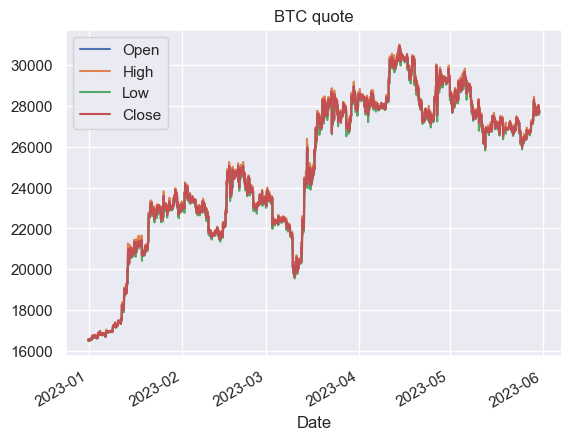

In [9]:
df_btc.plot(y=['Open','High','Low','Close'])
plt.title('BTC quote')
plt.show()

Look at last day

In [ ]:
df_btc.iloc[-48:].plot(y=['Open','High','Low','Close'])
plt.title('BTC quote for last day')
plt.show()

In [11]:
decompose = seasonal_decompose(df_btc['Close'], period=1*48)

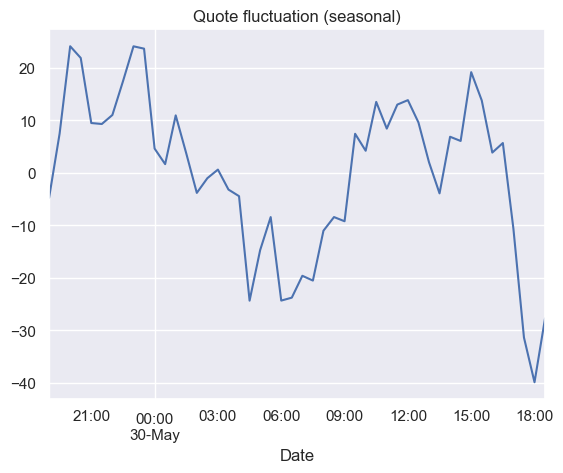

In [12]:
decompose.seasonal[-48:].plot()
plt.title('Quote fluctuation (seasonal)')
plt.show()

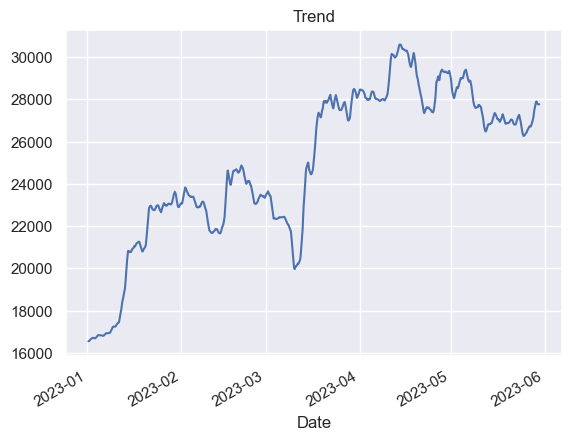

In [13]:
decompose.trend.plot()
plt.title('Trend')
plt.show()

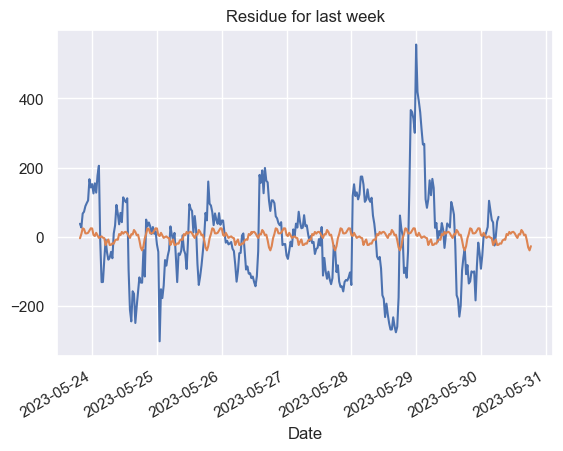

In [14]:
decompose.resid[-7*48:].plot()
decompose.seasonal[-7*48:].plot()
plt.title('Residue for last week')
plt.show()

**The remainder of the quotes significantly exceeds the magnitude of fluctuations, indicating the absence of a clear seasonality.**

Let's test the stationarity of the time series using the Dickey-Fuller test. In this case, the hypotheses are as follows:

- The null hypothesis assumes that the process is non-stationary.
- The alternative hypothesis, accordingly, states the opposite.

In [15]:
adf_test = adfuller(df_btc['Close'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.21613235079604765


Time series is non-stationary

Plot phik matrix

interval columns not set, guessing: ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume']


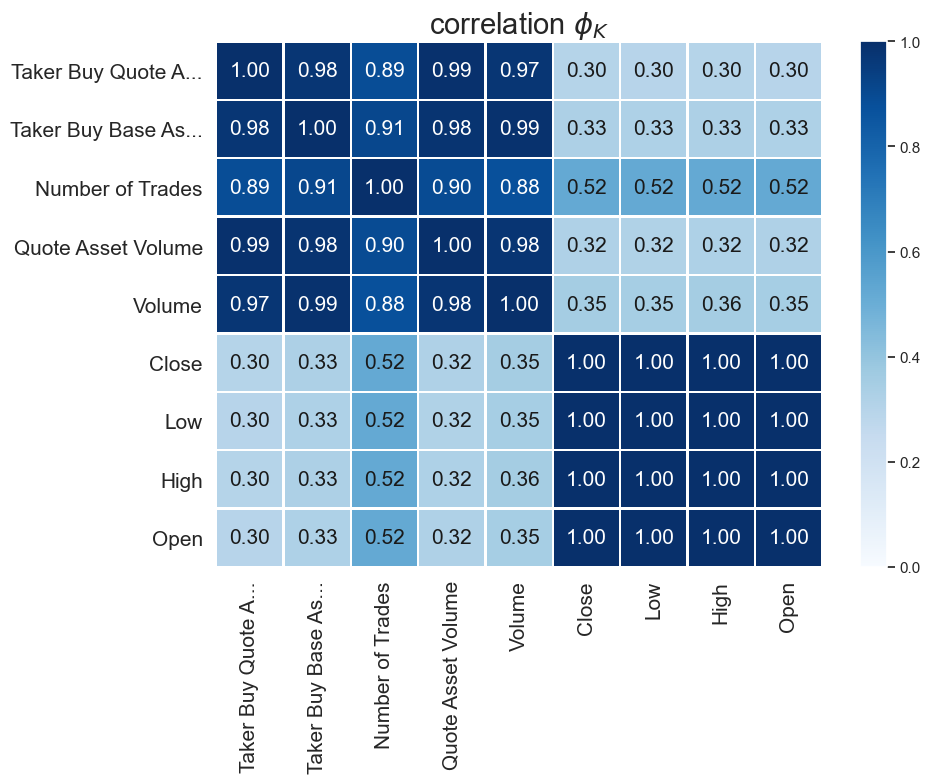

In [16]:
phik_overview = df_btc.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

**Since most of the features correlate with each other, we will leave only Close, Taker Buy Base Asset Volume и Number of Trades**

## Model train

To evaluate the model results, let's start by creating a simple linear regression.

For the "Close" column, we will calculate the lags with a step of 30 minutes up to 2 days, and we will also shift the other two features to avoid data leakage.

In [17]:
btc = df_btc[['Close','Taker Buy Base Asset Volume','Number of Trades']]
for lag in range(2, 48):
    btc['lag_{}'.format(lag)] = btc['Close'].shift(lag)
btc['lag_TBBAV'] = btc['Taker Buy Base Asset Volume'].shift(2)
btc['lag_NT'] = btc['Number of Trades'].shift(2)
btc = btc.dropna()

In [18]:
target = btc['Close']
feature = btc.drop(['Close','Taker Buy Base Asset Volume','Number of Trades'],axis=1)

Prepare feaures and scale these

In [19]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, target,shuffle=False,test_size=.3)
feature_valid, feature_test, target_valid, target_test = train_test_split(feature_test, target_test,shuffle=False,test_size=.5)
scale = MinMaxScaler()
scale.fit(feature_train)
feature_train = scale.transform(feature_train)
feature_valid = scale.transform(feature_valid)
feature_test  = scale.transform(feature_test)

Train linear regression

RMSE =  160.49811011448585
MAE =  9.544078087926184


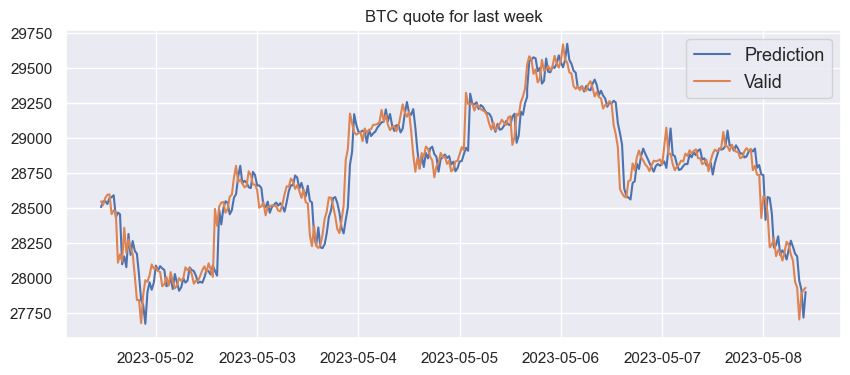

In [20]:
model_lr = LinearRegression()
model_lr.fit(feature_train,target_train)
predict_lr = pd.DataFrame(model_lr.predict(feature_valid),index=target_valid.index)
plt.figure(figsize=(10, 4))
plt.plot(predict_lr[-48*7:],label='Prediction')
plt.plot(target_valid[-48*7:],label='Valid')
plt.legend(loc="best", fontsize=13)
plt.title('BTC quote for last week')
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_lr)))
print('MAE = ',np.sqrt(mean_absolute_error(target_valid,predict_lr)))

Linear regreession: MAE = 11.5

Text(0.5, 1.0, 'BTC quote for valid period')

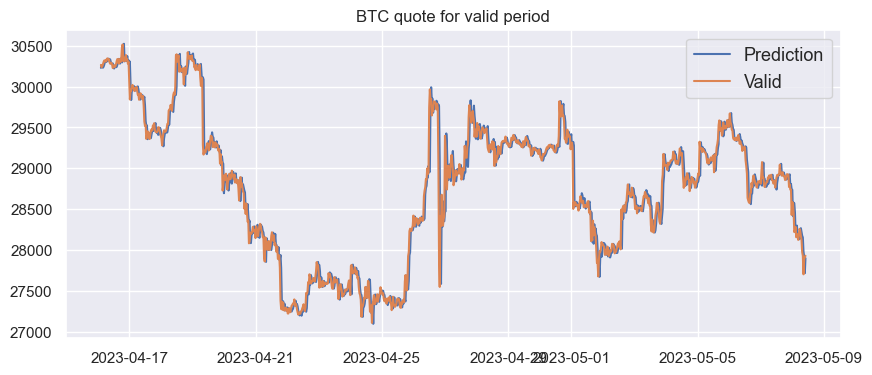

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(predict_lr,label='Prediction')
plt.plot(target_valid,label='Valid')
plt.legend(loc="best", fontsize=13)
plt.title('BTC quote for valid period')

**In order to speed up the LSTM model training, we will predict the time series using only one column.**

In [22]:
ts = df_btc['Close'].values

In [23]:
ts_train, ts_test = train_test_split(ts, shuffle=False,test_size=.3)
ts_valid, ts_test = train_test_split(ts_test, shuffle=False,test_size=.5)

The code below prepares the data for the LSTM model. Since we need to predict the next hour, the "output_steps" parameter is set to 2 (since each step is 30 minutes). We will train the model with a window size of 15 steps.

In [24]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 15, 2
# split into samples
X, y = split_sequence(ts_train, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [25]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(80, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.fit(X, y, epochs = 200, batch_size = 32)

Epoch 1/200
158/158 [==============================] - 7s 25ms/step - loss: 74283776.0000
Epoch 2/200
158/158 [==============================] - 4s 24ms/step - loss: 1026423.1875
Epoch 3/200
158/158 [==============================] - 3s 22ms/step - loss: 2189047.0000
Epoch 4/200
158/158 [==============================] - 4s 22ms/step - loss: 86913.5312
Epoch 5/200
158/158 [==============================] - 4s 22ms/step - loss: 87156.4062
Epoch 6/200
158/158 [==============================] - 4s 25ms/step - loss: 31904210.0000
Epoch 7/200
158/158 [==============================] - 4s 24ms/step - loss: 150370544.0000
Epoch 8/200
158/158 [==============================] - 4s 22ms/step - loss: 96319.9375
Epoch 9/200
158/158 [==============================] - 4s 23ms/step - loss: 96578.8047
Epoch 10/200
158/158 [==============================] - 4s 25ms/step - loss: 96529.4062
Epoch 11/200
158/158 [==============================] - 4s 26ms/step - loss: 131716.8125
Epoch 12/200
158/158 [====


KeyboardInterrupt



In [28]:
X_valid, y_valid = split_sequence(ts_valid, n_steps_in, n_steps_out)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))

In [29]:
y_predict = model.predict(X_valid)

34/34 [==============================] - 3s 11ms/step


RMSE =  142.50797482376154
MAE =  10.166174322335452


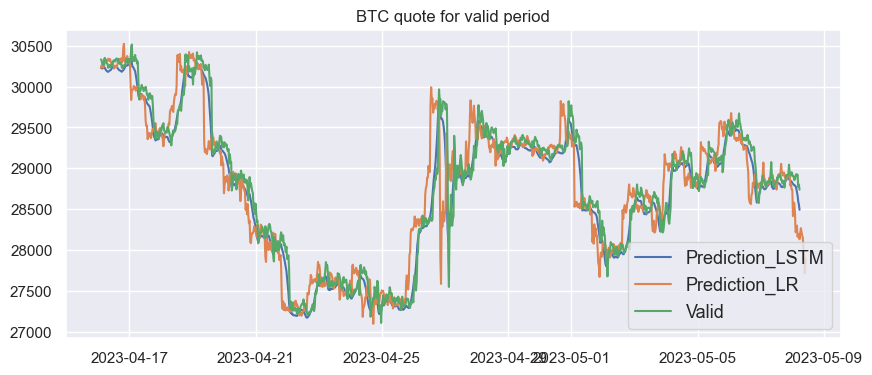

In [30]:
predict_lstm = pd.DataFrame(y_predict)
predict_lstm.index = predict_lr.index[:len(predict_lstm)]
valid_lstm = pd.DataFrame(ts_valid[:len(predict_lstm[0])])
valid_lstm.index = predict_lr.index[:len(predict_lstm)]
plt.figure(figsize=(10, 4))
plt.plot(predict_lstm[0],label='Prediction_LSTM')
plt.plot(predict_lr,label='Prediction_LR')
plt.plot(valid_lstm,label='Valid')
plt.legend(loc="best", fontsize=13)
plt.title('BTC quote for valid period')
print('RMSE = ',np.sqrt(mean_squared_error(predict_lstm[0],valid_lstm[0])))
print('MAE = ',np.sqrt(mean_absolute_error(predict_lstm[0],valid_lstm[0])))

**Conclusion: The LSTM model demonstrated the best MAE. The LSTM graph shows that the model closely follows local extrema and fluctuations. Despite smoothing out peaks, the LSTM model better predicts the overall trend.**

Let's see the result on the test sample

34/34 [==============================] - 0s 12ms/step
RMSE =  222.4819840020319
MAE =  12.612824331150666


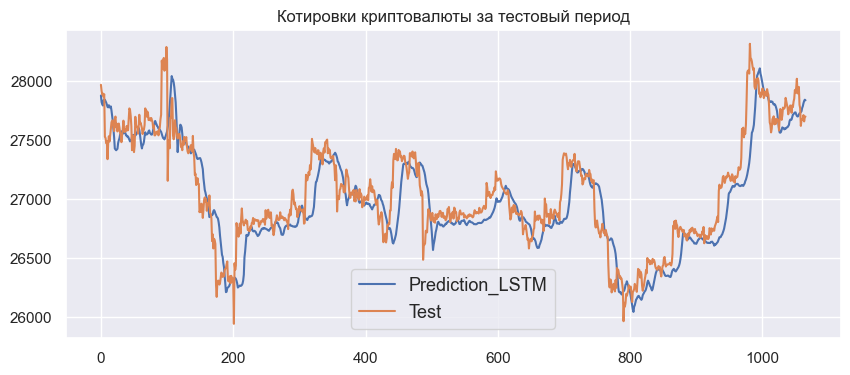

In [31]:
X_test, y_test = split_sequence(ts_test, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
test_predict = model.predict(X_test)
predict_lstm = pd.DataFrame(test_predict)
test_lstm = pd.DataFrame(y_test)
plt.figure(figsize=(10, 4))
plt.plot(predict_lstm[0],label='Prediction_LSTM')
plt.plot(test_lstm[0],label='Test')
plt.legend(loc="best", fontsize=13)
plt.title('Котировки криптовалюты за тестовый период')
print('RMSE = ',np.sqrt(mean_squared_error(predict_lstm[0],test_lstm[0])))
print('MAE = ',np.sqrt(mean_absolute_error(predict_lstm[0],test_lstm[0])))

**It can be seen from the test sample that the model smooths out the peaks, but it shows the general trend quite well.**

Output predictions for the next hour

In [32]:
test_predict[-1]

array([27838.648, 27859.643], dtype=float32)

The metric values:

- RMSE =  222
- MAE =  12